# LSTM baseline

from kuto

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import os
import sys
import glob
import pickle
import random

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [11]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 500
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 54
IS_SAVE = True

utils.set_seed(SEED)

In [12]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [13]:
train_df = pd.read_csv(WIFI_DIR / 'train_10_th10000_base25_withdelta.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10_th10000_base25_allwifibase_withdelta.csv')

In [14]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [15]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
DELTA_FEATS  = ['delta_x', 'delta_y']

In [16]:
train_df.iloc[:, 100:110]

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9
0,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,a77f8e93896f8fc8bc0d0700ca04b802ee79a07f,1b2fd184314ae440900fa9ce1addeb896b5604a9,2c09230bb32ee49f6a72928f6eeefb6885dc15ce,3799b46aa4cf6c3c45c0bc27d8f1efefea96914f,fc6956beb062b5158252c66953e92a0d25495cac,c71a2f5c4282d27f84b9b841db0e310ef0fcf6cd,4f8b7c168dc76c9d3b4ca7903042173e98fe2ddb
1,e9b24f94c0007acb4b7169b945622efcd332cf6f,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,d32dd11040b254cd889c9ead2d4a50f6e3900196,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,1b2fd184314ae440900fa9ce1addeb896b5604a9,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,fc6956beb062b5158252c66953e92a0d25495cac
2,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,509d1f842b0773e85c6beec0bb530542efd35cb9,b2337b25e7d1df04928bf6698a9c0b2764df7795,76f81d5047273fa64a434457531d400fc5d90fac,6e388d1db5ba8dd9de80522a4ddf50402cf443b3,8c6ab78f2797e076f9106af81090d0ab9904f5cd,ceccac4f0e50ec9e36e8d2800b8f2c7c3b4d903e,f920a2e4cb52165850990d9d37d391b630f7de14
3,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,e9b24f94c0007acb4b7169b945622efcd332cf6f,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,d32dd11040b254cd889c9ead2d4a50f6e3900196,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,0452e85d0a41780463cfe079077ea5bd2f519c7a
4,5875360455060f20a3cba705f44a4e3987c9b9f3,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,0452e85d0a41780463cfe079077ea5bd2f519c7a,3c7e7fa0576bc8a2af71d5899581df36f4dab6c8,09e103887f42552d20328aa41891cf82dace79ab,54bba3a36204f8c71b93798c31f9e0b039914575,18067f8d8861af3bcae51ba04b6b11b9150b9ff2,591ea59cf88e3397db5d60eb00a5147edd69399a,f920a2e4cb52165850990d9d37d391b630f7de14,d32dd11040b254cd889c9ead2d4a50f6e3900196
...,...,...,...,...,...,...,...,...,...,...
251108,5964a27e0cb3344b0a18540e6b3120c433971c38,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,346b34a42e801c64e043dbaacbe7fef9b8880774,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,5f583dcccc43b5b7ac25d270e29c92d878fb2be0,4d2e5639041b40b0df2ee258aa504bd904133d80,dfc21edb1f7650d5645fd672bbe6a13fc6fd77f8,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9
251109,5964a27e0cb3344b0a18540e6b3120c433971c38,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,4b5dbdb52b131410ea10b59ea451de62280b41d6,4d2e5639041b40b0df2ee258aa504bd904133d80,f4107af4418d57aacb3542343f7b47768debdc75,5f583dcccc43b5b7ac25d270e29c92d878fb2be0
251110,346b34a42e801c64e043dbaacbe7fef9b8880774,5964a27e0cb3344b0a18540e6b3120c433971c38,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,4b5dbdb52b131410ea10b59ea451de62280b41d6,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9,ee5ca7a7deaacdcd5d99355ff5f156dc45b74efa,a7986c0cea5d2571ea42011ab4407039e977c0bd
251111,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,5964a27e0cb3344b0a18540e6b3120c433971c38,f4107af4418d57aacb3542343f7b47768debdc75,cce41299a022ada08aebf3d309acb07d5f00b014,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,a7986c0cea5d2571ea42011ab4407039e977c0bd,180a351ec58c07d60949862c534373c43f548a9a,4d2e5639041b40b0df2ee258aa504bd904133d80


bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [17]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61592
BSSID TYPES(test): 28283
BSSID TYPES(all): 89875


In [18]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 97
RSSI TYPES(test): 82
RSSI TYPES(all): 179


## PreProcess

In [19]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,DELTA_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    output_df.loc[:,DELTA_FEATS] = ss.transform(output_df.loc[:,DELTA_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id,delta_x,delta_y
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469851129,157.99141,102.125390,-1.0,B1,5e158ef61506f2000638fd1f,0,-0.025217,-0.014531
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5765,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5825,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.446463,0.506216
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,5765,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,0,0.504093,0.398055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251108,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1556355684145fce5e67ba749d943a180266ad90,...,0,1573733061352,203.53165,143.513960,6.0,F7,5dcd5c9323759900063d590a,23,0.121631,0.362279
251109,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,0,1573733070079,192.57130,145.781450,6.0,F7,5dcd5c9323759900063d590a,23,-2.376529,0.568969
251110,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd

In [20]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [21]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.delta_feats = df[DELTA_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx],
            'delta':self.delta_feats[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [22]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
#         self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
        self.delta = nn.Sequential(
            nn.BatchNorm1d(2),
            nn.Linear(2, 2 * 64)
        )
        
        concat_size = 64 + (2 * NUM_FEATS * 64) + 64 * 2
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['RSSI_BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)
        
        x_delta = self.delta(x['delta'])


        x = torch.cat([x_bssid, x_delta, x_site_id], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [23]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [24]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [25]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [26]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [27]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 165.57598876953125


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 131.16354030131166


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 105.38810745188427


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 91.02193359106094


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 84.65731006403419


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 82.54272608016092


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 82.14614156710316


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 82.1859891068774


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 65.13799634728923


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 56.28392438562665


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 45.11075933113319


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 37.97509463576893


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 32.323071592934745


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 27.807224537771337


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 23.638973471479417


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 20.473741299358462


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 17.90718514745578


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 15.852755212179185


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 14.233720899627409


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 14.107647222522612


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 12.87061551399649


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.26862910740252


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.882247210420026


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.23620184370197


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.872800619710318


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.639100412438049


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.264387415425382


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.818078057268423


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.969751165473228


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.549169061723484


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.403365510370355


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.488033371434886


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.716350080734834


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.661051664715194


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.29663538589494


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.233485157300702


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.761974840760615


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.166534377097468


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.377548879176192


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.877552830786083


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.939837162145717


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.848387445707667


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.893567809386328


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.80759656575324


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.176114120663763


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.101196750117813


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.061294481776336


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.012297904647705


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.016087192426363


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 6.983166430243979


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 6.971831843029574


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 6.964907462945836


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 6.96241183519722


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 6.93225773272913


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.973785790632598


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.9363748250969905


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.922657447913731


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.9283999530264255


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.8953713825536544


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.903553994834846


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.8988489478013095


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.888660917275955


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.881837620316027


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.883828755837216


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.8749775605229395


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.87956653813662


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.881578732018519


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.878811400551041


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.884886202032326


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.888479326710557


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.886302406752517


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.876764014231988


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.877574777592901


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.8833599043947995


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.876581254221664


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.883460454061522


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.881221882225543


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.871212542710344


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.878608261721635


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.878109378863887


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.87692330018336


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.87842981758462


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.871011550058069


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.87575991656379


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.8821108281266525
fold 0: mean position error 6.888334558289558
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,42.16145
Loss/xy,42.16145
Loss/floor,5.61161
MPE/val,6.88833
epoch,83
trainer/global_step,33011
_runtime,385
_timestamp,1619846815
_step,83


Loss/val,█▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,█████▃▄▄▃▁▅▆▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
MPE/val,█▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 140.84415817260742


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 139.29194834512612


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 116.9680453500721


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 100.78587762335411


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 90.24595850000271


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 84.1253778960611


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 69.70589459667455


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 61.75323133347702


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 46.90897556942764


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 39.052192512133445


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 32.981122910937984


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 28.61000001720016


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 25.11633119351526


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 21.909075684120083


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 19.378647404897606


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 17.137033687569417


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 15.54614726113115


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 14.137088246840497


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 13.402856471895685


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 12.258663981954385


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.595438750103266


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.525157270343385


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.385224959990197


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.841975472805041


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.811708009245573


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.432163804622203


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 8.94947860964954


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.302984633856683


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.22718872953276


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.903501802994159


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.481247715403796


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.026448232907775


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 10.001544548213392


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.26908354120769


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.369680145697366


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.248220419745381


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.13258455277719


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.05754980814475


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.683198628773004


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.351672682176988


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.26515980010747


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.977837802055649


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.194307728580268


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.212448857047342


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.15414720552085


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.007744801830993


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.34060203247677


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.2404345878856855


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.202642767193136


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.1881526622776315


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.201163234235189


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.147770253760877


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.145161024094038


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.124283267635441


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.126837677425808


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.143757501110681


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.133470418246721


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.118563544947486


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.070117636800914


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.067340205055448


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.076968916713256


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.062959671276706


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.082265231575014


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.066621104389423


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.0523326935471955


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.067597624924063


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.074002626606809


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.051607412239467


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.066167667761122


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.066220830082765


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.058506669471424


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.064274298921851


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.060266453246775


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.056313737192489


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.0510837013634875


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.06074623228426


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.053578654796929


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.050106680267682


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.05471979692985


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.056120300969333


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.0576237658646805


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.051444923137302


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.055578884708479


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.061437579603213


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.0631398600248945


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.056500738317316


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.052841138050629


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.060282854477411
fold 1: mean position error 7.021155132700377
Fold 2


Loss/val,40.74502
Loss/xy,40.74502
Loss/floor,4.93274
MPE/val,7.02115
epoch,86
trainer/global_step,34190
_runtime,401
_timestamp,1619847224
_step,86


Loss/val,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▅▅▅█▁▃▃▃▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 169.98239517211914


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 135.96305012902778


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 114.17666965593658


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 98.52721340508198


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 88.38304259027431


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 82.63681017402011


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 80.0749212708136


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 79.33352849531143


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 79.41043769398634


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 60.75588650952456


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 56.13119829605401


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 53.469164974377435


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 51.91361415706449


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 50.70811565865656


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 49.73220249506419


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 49.231453804771995


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 48.73861624157969


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 48.261675014204805


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 42.5242334794619


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 33.24878770326917


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 26.876386595827878


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 22.24154827657782


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 18.871659676797563


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 17.088269687175444


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 15.513192461609407


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 13.867738780016133


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 13.54409882311613


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 12.397677712304192


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 12.917620487426293


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 11.334753099318965


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 10.943667324594138


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 10.430082297596705


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 10.367703934625839


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 10.418753845523103


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 10.130065381181078


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.37741691651663


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.298420858004006


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.165899074131408


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.963393772235102


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.810464450832901


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.019113509598123


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.648108809577913


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 9.028126764676658


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.926147845133181


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.478357969087707


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.367616433213916


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.304612757389505


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.340984465818162


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.744825653996028


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.161368958800935


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.287940720960501


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.717642603959675


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.250170231787795


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.149252681252573


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.102226713153078


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.403799839950288


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.040514873325915


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.026823591473741


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.528474513828023


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.542094784861044


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.8981378514511


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.001568280930625


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.004196108578867


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.60903807914106


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.145797525148046


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.487369262196032


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.378241665666138


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.336994317380839


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.289253296965864


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.266767631775072


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.232552865590174


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.235606496266952


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.222347843654689


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.241108816771155


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.211592819468836


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.207127577459687


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.204855824295691


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.178736169697417


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.196016671246107


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.183074283261671


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.179287545736852


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.13146576859888


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.166638827083086


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.1348091140245335


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.167751797855016


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.1578614475546205


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.118782266042526


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.125489500858643


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.125988226410344


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.118530220967991


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.128142893865189


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.1223325124741015


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.117557508776886


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.115864344624943


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.117380770308829


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.1173857067468065


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.114174311939373


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.113570138764028


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.116116662551172


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.115262462276554


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.1165361729278995


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 7.114464363999555


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 7.115571137835537


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 7.116245354628425


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 7.115916292154479


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 7.115386566192443


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 7.113289899936728


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 7.11587660558091


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 7.112101164474914


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 7.112457308235308


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 7.121022470479572


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 7.115135615086674


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 7.112897056470552


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 7.115656365073422


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 7.113049653174415


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 7.116159202512966


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 7.115589278963287


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 7.114253144814536


Validating: 0it [00:00, ?it/s]

epoch = 117, mpe_loss = 7.118887834489512


Validating: 0it [00:00, ?it/s]

epoch = 118, mpe_loss = 7.111222758335168


Validating: 0it [00:00, ?it/s]

epoch = 119, mpe_loss = 7.111547841888434


Validating: 0it [00:00, ?it/s]

epoch = 120, mpe_loss = 7.113610147430696


Validating: 0it [00:00, ?it/s]

epoch = 121, mpe_loss = 7.114827092427119


Validating: 0it [00:00, ?it/s]

epoch = 122, mpe_loss = 7.11653344138781


Validating: 0it [00:00, ?it/s]

epoch = 123, mpe_loss = 7.112376067245388


Validating: 0it [00:00, ?it/s]

epoch = 124, mpe_loss = 7.115492685005636


Validating: 0it [00:00, ?it/s]

epoch = 125, mpe_loss = 7.113117647253004


Validating: 0it [00:00, ?it/s]

epoch = 126, mpe_loss = 7.1127623488460845


Validating: 0it [00:00, ?it/s]

epoch = 127, mpe_loss = 7.1165812265583455


Validating: 0it [00:00, ?it/s]

epoch = 128, mpe_loss = 7.114172404232062


Validating: 0it [00:00, ?it/s]

epoch = 129, mpe_loss = 7.115760427071616


Validating: 0it [00:00, ?it/s]

epoch = 130, mpe_loss = 7.115700704472926


Validating: 0it [00:00, ?it/s]

epoch = 131, mpe_loss = 7.113481923069924


Validating: 0it [00:00, ?it/s]

epoch = 132, mpe_loss = 7.1146657583202675


Validating: 0it [00:00, ?it/s]

epoch = 133, mpe_loss = 7.1164348603012275


Validating: 0it [00:00, ?it/s]

epoch = 134, mpe_loss = 7.114624434226615


Validating: 0it [00:00, ?it/s]

epoch = 135, mpe_loss = 7.116765414671874


Validating: 0it [00:00, ?it/s]

epoch = 136, mpe_loss = 7.113785637237168


Validating: 0it [00:00, ?it/s]

epoch = 137, mpe_loss = 7.115943281260609


Validating: 0it [00:00, ?it/s]

epoch = 138, mpe_loss = 7.112692226677998


Validating: 0it [00:00, ?it/s]

epoch = 139, mpe_loss = 7.115347648163956


Validating: 0it [00:00, ?it/s]

epoch = 140, mpe_loss = 7.117867395592432


Validating: 0it [00:00, ?it/s]

epoch = 141, mpe_loss = 7.117815929255433


Validating: 0it [00:00, ?it/s]

epoch = 142, mpe_loss = 7.114343730962176


Validating: 0it [00:00, ?it/s]

epoch = 143, mpe_loss = 7.118431913962857


Validating: 0it [00:00, ?it/s]

epoch = 144, mpe_loss = 7.11069653763352


Validating: 0it [00:00, ?it/s]

epoch = 145, mpe_loss = 7.1137167503058505


Validating: 0it [00:00, ?it/s]

epoch = 146, mpe_loss = 7.115143520458524


Validating: 0it [00:00, ?it/s]

epoch = 147, mpe_loss = 7.113386024179547


Validating: 0it [00:00, ?it/s]

epoch = 148, mpe_loss = 7.113766234996573


Validating: 0it [00:00, ?it/s]

epoch = 149, mpe_loss = 7.1133526747851334


Validating: 0it [00:00, ?it/s]

epoch = 150, mpe_loss = 7.114140101102202


Validating: 0it [00:00, ?it/s]

epoch = 151, mpe_loss = 7.114106792597112


Validating: 0it [00:00, ?it/s]

epoch = 152, mpe_loss = 7.116192693482822


Validating: 0it [00:00, ?it/s]

epoch = 153, mpe_loss = 7.114766788872088


Validating: 0it [00:00, ?it/s]

epoch = 154, mpe_loss = 7.110375682589778


Validating: 0it [00:00, ?it/s]

epoch = 155, mpe_loss = 7.112673290104295


Validating: 0it [00:00, ?it/s]

epoch = 156, mpe_loss = 7.115334902889827


Validating: 0it [00:00, ?it/s]

epoch = 157, mpe_loss = 7.113904283811732


Validating: 0it [00:00, ?it/s]

epoch = 158, mpe_loss = 7.112106013600349


Validating: 0it [00:00, ?it/s]

epoch = 159, mpe_loss = 7.118243319384134


Validating: 0it [00:00, ?it/s]

epoch = 160, mpe_loss = 7.113509975964603


Validating: 0it [00:00, ?it/s]

epoch = 161, mpe_loss = 7.111412017954669


Validating: 0it [00:00, ?it/s]

epoch = 162, mpe_loss = 7.114064398104981


Validating: 0it [00:00, ?it/s]

epoch = 163, mpe_loss = 7.117493961335459


Validating: 0it [00:00, ?it/s]

epoch = 164, mpe_loss = 7.110525027977481


Validating: 0it [00:00, ?it/s]

epoch = 165, mpe_loss = 7.112610578332029


Validating: 0it [00:00, ?it/s]

epoch = 166, mpe_loss = 7.1110012565098755


Validating: 0it [00:00, ?it/s]

epoch = 167, mpe_loss = 7.120109780998402


Validating: 0it [00:00, ?it/s]

epoch = 168, mpe_loss = 7.1163951789541136


Validating: 0it [00:00, ?it/s]

epoch = 169, mpe_loss = 7.117337686744475


Validating: 0it [00:00, ?it/s]

epoch = 170, mpe_loss = 7.116401593915216


Validating: 0it [00:00, ?it/s]

epoch = 171, mpe_loss = 7.114246546466351


Validating: 0it [00:00, ?it/s]

epoch = 172, mpe_loss = 7.113494272516949


Validating: 0it [00:00, ?it/s]

epoch = 173, mpe_loss = 7.119153652656419


Validating: 0it [00:00, ?it/s]

epoch = 174, mpe_loss = 7.114699963930984


Validating: 0it [00:00, ?it/s]

epoch = 175, mpe_loss = 7.110479695654007


Validating: 0it [00:00, ?it/s]

epoch = 176, mpe_loss = 7.115613439429993


Validating: 0it [00:00, ?it/s]

epoch = 177, mpe_loss = 7.114182551650624


Validating: 0it [00:00, ?it/s]

epoch = 178, mpe_loss = 7.115329592504118


Validating: 0it [00:00, ?it/s]

epoch = 179, mpe_loss = 7.111367546202878


Validating: 0it [00:00, ?it/s]

epoch = 180, mpe_loss = 7.113578686323726


Validating: 0it [00:00, ?it/s]

epoch = 181, mpe_loss = 7.109550181496868


Validating: 0it [00:00, ?it/s]

epoch = 182, mpe_loss = 7.11312801115953


Validating: 0it [00:00, ?it/s]

epoch = 183, mpe_loss = 7.116739758516726


Validating: 0it [00:00, ?it/s]

epoch = 184, mpe_loss = 7.116412575465747
fold 2: mean position error 7.0801932099001
Fold 3


Loss/val,43.00668
Loss/xy,43.00668
Loss/floor,4.80663
MPE/val,7.08019
epoch,184
trainer/global_step,72704
_runtime,864
_timestamp,1619848096
_step,184


Loss/val,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▄▁██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
MPE/val,█▆▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 129.3927459716797


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 134.29211575554606


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 110.649037000533


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 94.99781661102737


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 86.17587779601729


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 69.81286636841732


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 61.49157548484752


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 49.5904497947408


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 40.97258685166029


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 34.15422205114553


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 29.22309762488136


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 25.364526366894317


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 21.64798628053594


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 18.66340542802907


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 16.692536529345006


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 15.375550110297189


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 13.081625219076205


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 11.915543598096308


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.238945666770952


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 10.881467316828122


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 10.319817877464981


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.359429426239307


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.692383840935348


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.361082982744728


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 13.825159949695118


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.293904937774295


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.118604965570153


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.706659438686513


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.431992010636764


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.412490446838726


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.641991807956888


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.159088066287035


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.554770931006002


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.237596638955512


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.233862868096674


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.492974701396824


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.331225011764412


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.205416481066651


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.925856257301703


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.304147382551085


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.030560044693644


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.03358596052891


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.020771993269353


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.391486057755609


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.052076277316115


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.001538550167897


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.272106985696115


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.210353237314606


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.152578560155266


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.155802516912126


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.13695691811918


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.1270138908490095


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.12756707933214


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.09379116715074


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.088829984149757


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.108595470299468


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.091476252584746


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.088234000316984


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.098161029773791


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.0849426572763665


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.10714872206938


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.052916101473279


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.04775684446319


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.033118768800074


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.033668536494896


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.028466064258788


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.033545585174963


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.035234688979573


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.036326107457379


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.03454934268025


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.033063685627009


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.034480560229021


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.035165212947023


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.037502070817709


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.029105793555473


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.0307536977500735


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.031954812438121


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.034101462332784


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.031084015644796


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.025848769597124


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.027833583431386


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.040480416858725


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.03129092129794


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.036208279885688


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.03437433401953


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.031697390317183


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.030197337472653


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.0219263307976


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.0353937469452275


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.033462637707388


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.032709752670442


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.035746194942509


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.025330948525999


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.032840963723003


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.037408712719635


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.026331743023403


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.029573090619877


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.026710697680018


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.031206263540919


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.0226170910938714


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.0346180244030325


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 7.025205122571165


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 7.0351121596301605


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 7.029948915783962


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 7.033892089146818


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 7.032978021213764


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 7.034392705338536


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 7.029394679808752


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 7.038452111789936


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 7.031709595002989


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 7.025351637436938


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 7.027505039278751


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 7.03153780316071


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 7.026367139125216


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 7.04294211015295


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 7.035972637726018


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 7.023114517062811


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 7.02889569998311
fold 3: mean position error 7.02511631712557
Fold 4


Loss/val,39.95557
Loss/xy,39.95557
Loss/floor,4.58753
MPE/val,7.02512
epoch,116
trainer/global_step,45980
_runtime,547
_timestamp,1619848651
_step,116


Loss/val,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁█▅▃▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
MPE/val,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.425    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 127.89968872070312


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 126.33267598912336


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 99.70164590432658


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 80.37530644399637


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 68.81206196905177


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 61.6759595288799


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 56.558212974692424


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 53.08694886553952


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 51.19327817698241


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 49.84490354803501


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 47.22498827897827


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 39.87351017852703


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 33.95397839443591


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 26.426818815406396


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 22.587237670539917


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 19.08760886638375


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 16.492754195937476


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 14.550448222698535


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 13.196326138944965


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 12.467713860288542


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.473716539827732


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.748340527111887


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.631553443000671


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.045966989595115


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.987902565069454


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.901313472432843


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.29025437636076


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.170297939734445


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.184431052176535


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.0816784143762


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.336411160756791


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.070484510890005


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.899786720476918


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.291920758466423


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.27590798745304


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.567932935990312


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.418522478982341


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.18364189715044


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.127436641438468


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.090360134067796


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.976232456857298


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.169614979715059


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.435982888238074


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.216829518346238


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.917310758070513


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.759495458950534


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.13524285878955


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.168127768386285


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.096662876529551


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.3934355242816725


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.288526511579739


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.2632427602993275


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.229604094291289


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.222242281213894


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.186268903625917


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.192684752929614


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.17160946243313


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.158798167932751


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.150049728628937


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.160364992324333


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.140174905197318


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.1413127876553135


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.129142159582179


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.108517658516771


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.12156649289238


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.118993335509436


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.139650105278273


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.120965664356385


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.080155354819383


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.068359866705598


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.070832814885484


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.054176337477089


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.05406186525163


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.057133612634845


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.045513636614598


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.049964291095524


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.0437795700187165


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.04484199032639


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.043108609039949


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.053816510859319


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.05075252616306


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.044081568665603


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.03882837578242


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.0444278945302985


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.044256001121913


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.0471205043332015


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.049160356525794


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.0506745758525735


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.042572286498615


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.044432877133067


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.043997813590431


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.042441754263642


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.043457461701814


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.0460523270073825


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.043458007959928


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.046577193310871


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.043828783089726


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.0369090737613815


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.042801673233273


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.045239568541958


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.0441119645738155


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 7.045555467609779


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 7.043519111385354


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 7.043068728951649


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 7.03887724436633


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 7.036774551758496


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 7.0433155856846605


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 7.042436901916786


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 7.049030792938287


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 7.041286156373324


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 7.042627792689274


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 7.044838347872674


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 7.04586726717641


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 7.039850204201398


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 7.041809328407586


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 7.0428468812491


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 7.043782582134336


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 7.0473667465389225
fold 4: mean position error 7.070248462595272


In [83]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,161.206253,103.055817,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,161.951157,106.871330,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,164.370087,111.375954,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,161.412933,111.661339,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,162.208420,111.909943,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
251108,194.602859,138.821487,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251109,193.100433,144.384308,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251110,190.772797,144.126465,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
251111,189.663864,142.369705,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [29]:
oofs_df_dupli = oofs_df[~oofs_df.duplicated(subset='timestamp')].sort_values('timestamp').reset_index(drop=True)

In [30]:
oofs_df_dupli[['path', 'timestamp', 'site']]

,path,timestamp,site
0,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b
1,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b
2,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b
3,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b
4,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b
...,...,...,...
70727,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266
70728,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266
70729,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266
70730,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266


In [31]:
oofs_df_gby = oofs_df.groupby('timestamp').mean()[['x', 'y']].sort_index().reset_index(drop=True)
oofs_df_gby[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']] = oofs_df_dupli[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']]
oofs_df_gby.to_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv", index=False)
oofs_df_gby

,x,y,path,timestamp,site,site_path_timestamp,floor
0,164.947556,36.590771,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
1,187.126251,28.175081,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
2,192.185211,88.893463,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
3,186.174393,85.827621,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
4,184.046234,87.927322,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0
...,...,...,...,...,...,...,...
70727,66.026741,179.396332,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
70728,60.100151,180.633438,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
70729,49.616386,182.238251,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
70730,44.787487,181.450790,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0


In [32]:
train_df_gby = train_df.groupby('wp_tmestamp').mean()[['x', 'y']]

In [33]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
oofs_score_gby = mean_position_error(
        oofs_df_gby['x'], oofs_df_gby['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}, CV_gby:{oofs_score_gby}")

CV:7.017009291826948, CV_gby:6.485192996194245


In [34]:
fold_mean_xy = 0
for i in range(len(predictions)):
    fold_mean_xy += predictions[i][['x', 'y']]
fold_mean_xy = fold_mean_xy / 5
fold_mean_xy

,x,y
0,70.826523,86.271774
1,78.395210,85.591370
2,71.692406,84.318436
3,68.977089,81.750175
4,71.107201,83.229691
...,...,...
37395,131.402954,183.938019
37396,132.909958,180.951141
37397,132.653030,177.574295
37398,130.252228,173.830261


In [35]:
fold_mean_xy['site_path_timestamp'] = predictions[0]['site_path_timestamp']

In [36]:
all_preds = fold_mean_xy.groupby('site_path_timestamp').mean()

In [37]:
# all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
# all_preds

In [38]:
all_preds_50 = pd.read_csv('../50/output/sub50.csv', index_col=0)
all_preds_50.index = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')['site_path_timestamp']
all_preds_50

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.71397,104.649240
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.89932,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.22545,105.812570
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.35129,107.935360
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.31835,108.258490
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,210.10178,100.415660
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.61255,101.582490
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,205.28879,106.346170


In [39]:
all_preds_merge = pd.merge(all_preds_50, all_preds, how='left', on='site_path_timestamp')[['floor', 'x_y', 'y_y']]
all_preds_merge = all_preds_merge.rename(columns={'x_y': 'x', 'y_y': 'y'})
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,NaN,NaN
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,208.028809,98.691971
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.221573,101.358078
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,203.621933,107.754578


In [40]:
all_preds_merge['floor'].fillna(all_preds_50['floor'], inplace=True)
all_preds_merge['x'].fillna(all_preds_50['x'], inplace=True)
all_preds_merge['y'].fillna(all_preds_50['y'], inplace=True)
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,208.028809,98.691971
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.221573,101.358078
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,203.621933,107.754578


In [41]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds_merge.index = sub.index
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,208.028809,98.691971
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.221573,101.358078
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,203.621933,107.754578


In [42]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds_merge['floor'] = simple_accurate_99['floor'].values
all_preds_merge.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,208.028809,98.691971
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.221573,101.358078
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,203.621933,107.754578


# Post Proccess

In [43]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [44]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [45]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)

In [46]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [47]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [48]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [49]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [50]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

100%|██████████| 10133/10133 [00:00<00:00, 28625.89it/s]


In [51]:
sub_df['txt_path'] = txt_pathes

In [52]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

626it [02:24,  4.34it/s]


In [53]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

100%|██████████| 70732/70732 [00:41<00:00, 1704.28it/s]


In [54]:
oofs_df['txt_path'] = txt_pathes

In [55]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm

10789it [16:50, 10.68it/s]


,site_path_timestamp,floor,x,y
0,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,164.559645,36.842270
1,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,187.514165,27.923581
2,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,195.621748,89.201711
3,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,182.737862,85.519369
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0,181.199319,85.720912
...,...,...,...,...
70727,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,64.796879,177.976204
70728,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,59.490760,179.756470
70729,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,50.971239,182.387402
70730,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,45.675051,184.684902


In [56]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv", index=False)

In [57]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.389434669465558


In [58]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [59]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv")

In [60]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [61]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [62]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [63]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [64]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)

  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [65]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [66]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [67]:
sub_pp = sub_pp.sort_index()
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.162830,104.450550,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.596040,98.605774,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.511300,107.841324,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,192.553130,111.863014,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [68]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [69]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,163.710890,36.197370,5c3c44b80379370013e0fd2b,5d08a2553f461f0008dac591,F1
1,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,183.158980,28.152115,5c3c44b80379370013e0fd2b,5d08a2553f461f0008dac591,F1
2,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,195.909590,90.654030,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,F3
3,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,F3
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,F3
...,...,...,...,...,...,...,...
70727,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,68.407646,177.942440,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
70728,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,61.413883,176.395230,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
70729,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,47.679752,178.775450,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
70730,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,49.308346,187.129460,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1


In [70]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}")

CV:4.855816246392979


In [71]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp_gby.csv", index=False)

In [72]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,42.6582
Loss/xy,42.6582
Loss/floor,5.13563
MPE/val,7.07025
epoch,116
trainer/global_step,45980
_runtime,557
_timestamp,1619849215
_step,116


Loss/val,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,█▇▇▇▆▅▃▂▂▁▁▂▂▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
MPE/val,█▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,4.85582
_runtime,2
_timestamp,1619850769
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [75]:
import matplotlib.pylab as plt

In [97]:
bad_index = np.union1d(np.where(np.abs(train_df['x'].values - oofs_df['x']) > 20)[0], np.where(np.abs(train_df['y'].values - oofs_df['y']) > 20)[0])

In [98]:
np.save(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_badindex.npy", bad_index)

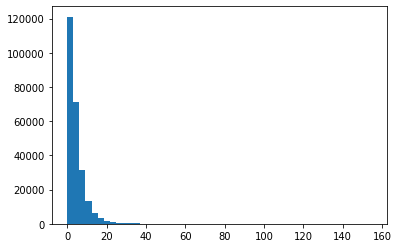

,count,mean,std,min,25%,50%,75%,max
x,251113.0,4.545734,5.041066,0.000034,1.487285,3.239056,5.944255,154.648984


In [87]:
plt.hist(np.abs(train_df['x'].values - oofs_df['x']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['x'].values - oofs_df['x'])).describe().T

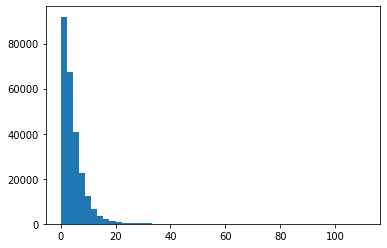

,count,mean,std,min,25%,50%,75%,max
y,251113.0,4.353171,4.28775,0.000007,1.470318,3.208053,5.868435,110.983953


In [88]:
plt.hist(np.abs(train_df['y'].values - oofs_df['y']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['y'].values - oofs_df['y'])).describe().T

In [ ]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

In [ ]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)